In [1]:
import scanpy as sc
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import seaborn as sns
import gffutils

In [2]:
import sys
sys.path.insert(0, "../lib")
import sankey
import sc_utils

In [4]:
mpl.font_manager.fontManager.addfont("../arial.ttf")
mpl.font_manager.fontManager.addfont("../Arial Italic.ttf")
mpl.font_manager.fontManager.addfont("../arialbd.ttf")

In [5]:
mpl.rcParams["figure.figsize"] = (12, 12)
mpl.rcParams["font.family"] = "Arial"
mpl.rcParams['pdf.fonttype'] = 42

# Plots for COVID-only object

In [6]:
ds = sc.read_h5ad("../data/02preprint/10obj-covid.h5ad")

Rename clusters to match text

In [8]:
ds.obs.cluster = ds.obs.cluster.astype(str)

In [9]:
ds.obs.cluster = ds.obs.cluster.str.replace("MoM_", "MoAM")

In [10]:
ds.obs.cluster.replace({
    "MoAM1, IL1R2": "MoAM1",
    "MoAM2, CCL18": "MoAM2",
    "MoAM3, VCAN":  "MoAM3",
    "TRAM":         "TRAM1",
    "TRAM, inf.":   "TRAM2",
    "pDCs":         "pDC",
    "Plf. CD4 T cells": "Proliferating CD4 T cells",
    "Plf. CD8 T cells": "Proliferating CD8 T cells",
}, inplace=True)

## General

... storing 'cluster' as categorical


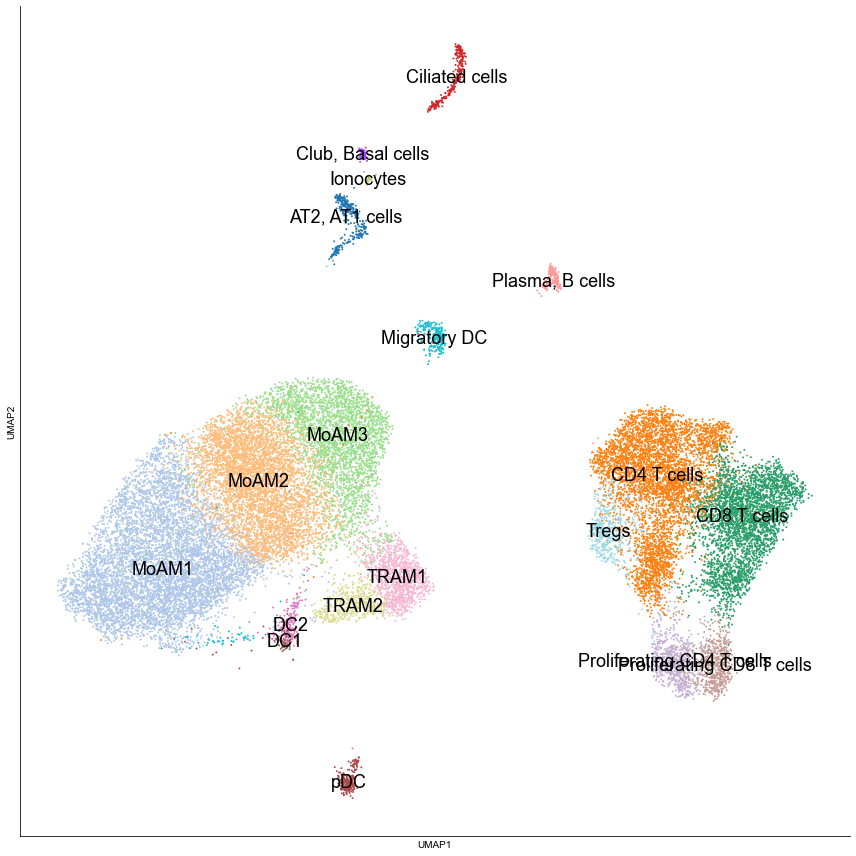

In [49]:
ax = sc.pl.umap(
    ds, 
    color="cluster", 
    size=15, 
    legend_loc="on data", 
    show=False, 
    legend_fontsize=18, 
    legend_fontweight="normal",
  #  legend_fontoutline=3
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("")
ax.figure.tight_layout()
ax.figure.savefig("11plots/4A_umap.pdf")

In [50]:
cluster_colors = pd.Series(ds.uns["cluster_colors"])

cluster_colors.index = ds.obs.cluster.cat.categories

cluster_colors.name = "color"

In [188]:
cluster_colors.to_csv("10obj-colors.tsv", index_label="metadataValue", sep="\t", header=True)

In [189]:
cluster_colors

AT2, AT1 cells               #1f77b4
CD4 T cells                  #ff7f0e
CD8 T cells                  #279e68
Ciliated cells               #d62728
Club, Basal cells            #aa40fc
DC1                          #8c564b
DC2                          #e377c2
Ionocytes                    #b5bd61
Migratory DC                 #17becf
MoAM1                        #aec7e8
MoAM2                        #ffbb78
MoAM3                        #98df8a
Plasma, B cells              #ff9896
Proliferating CD4 T cells    #c5b0d5
Proliferating CD8 T cells    #c49c94
TRAM1                        #f7b6d2
TRAM2                        #dbdb8d
Tregs                        #9edae5
pDC                          #ad494a
Name: color, dtype: object

## Composition plots

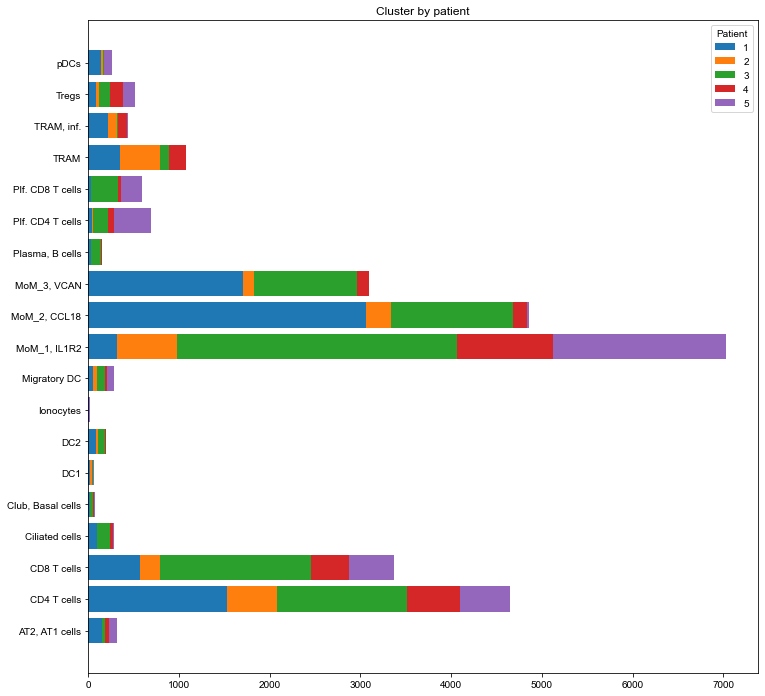

In [23]:
sc_utils.plot_composition(ds, "cluster", "patient")

In [55]:
cluster_str = ds.obs.cluster.astype(str)
am_tcells = cluster_str[cluster_str.str.match("MoAM|TRAM|.*T cells|Tregs")].unique()

/projects/b1038/tools/pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


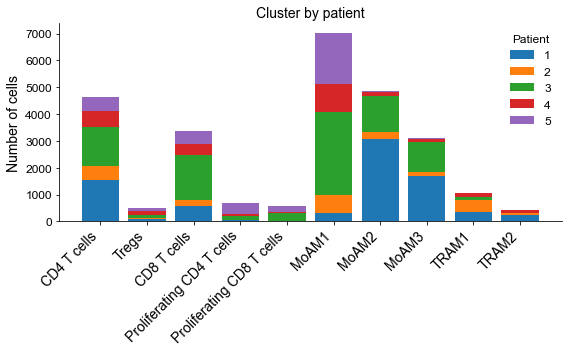

In [65]:
am_tcells_ds = ds[ds.obs.cluster.isin(am_tcells), :]
bottom = np.zeros(len(am_tcells_ds.obs.cluster.unique()))
fig, ax = plt.subplots(figsize=(8, 5))
for s in sorted(am_tcells_ds.obs.patient.astype(str).unique()):
    cnt = am_tcells_ds.obs.cluster[am_tcells_ds.obs.patient == s].value_counts().sort_index()
    cnt = cnt.loc[[
        "CD4 T cells", "Tregs", "CD8 T cells", 
        "Proliferating CD4 T cells", "Proliferating CD8 T cells",
        "MoAM1", "MoAM2", "MoAM3", "TRAM1", "TRAM2"
    ]]
    patient_num = am_tcells_ds.obs.patient[am_tcells_ds.obs.patient == s].values[0]
    ax.bar(cnt.index, cnt.values, bottom=bottom, label=patient_num)
    bottom += cnt
ax.legend(title="Patient", frameon=False, fontsize=12, title_fontsize=12)
ax.set_title("Cluster by patient", fontsize=14)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis="x", labelsize=14, rotation=45)
ax.tick_params(axis="y", labelsize=12)
ax.set_xticklabels([
    "CD4 T cells", "Tregs", "CD8 T cells", 
    "Proliferating CD4 T cells", "Proliferating CD8 T cells",
    "MoAM1", "MoAM2", "MoAM3", "TRAM1", "TRAM2"
], ha="right")
ax.set_ylabel("Number of cells", fontsize=14)
ax.figure.tight_layout()
ax.figure.savefig("11plots/S4A_composition.pdf")

/projects/b1038/tools/pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  # Remove the CWD from sys.path while we load stuff.


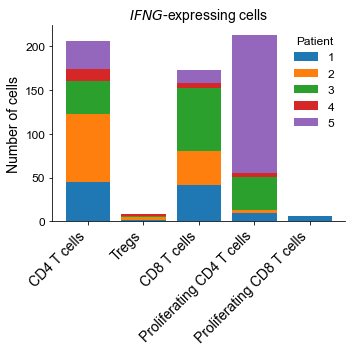

In [73]:
ifng_expr = ds.raw.X[:, ds.var_names == "IFNG"].A.reshape(-1)
tcells = cluster_str[cluster_str.str.match(".*T cells|Tregs")].unique()
tcells_ds = ds[ds.obs.cluster.isin(tcells) & (ifng_expr > 0), :]
bottom = np.zeros(len(tcells_ds.obs.cluster.unique()))
fig, ax = plt.subplots(figsize=(5, 5))
for s in sorted(tcells_ds.obs.patient.astype(str).unique()):
    cnt = tcells_ds.obs.cluster[tcells_ds.obs.patient == s].value_counts().sort_index()
    cnt = cnt.loc[[
        "CD4 T cells", "Tregs", "CD8 T cells", 
        "Proliferating CD4 T cells", "Proliferating CD8 T cells"
    ]]
    patient_num = tcells_ds.obs.patient[tcells_ds.obs.patient == s].values[0]
    ax.bar(cnt.index, cnt.values, bottom=bottom, label=patient_num)
    bottom += cnt
ax.legend(title="Patient", frameon=False, fontsize=12, title_fontsize=12)#, bbox_to_anchor=(1, 0.5), loc="center left")
ax.set_title("$IFNG$-expressing cells", fontsize=14)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis="x", labelsize=14, rotation=45)
ax.tick_params(axis="y", labelsize=12)
ax.set_xticklabels([
    "CD4 T cells", "Tregs", "CD8 T cells", 
    "Proliferating CD4 T cells", "Proliferating CD8 T cells"
], ha="right")
ax.set_ylabel("Number of cells", fontsize=14)
ax.figure.tight_layout()
ax.figure.savefig("11plots/S4B_ifng_composition.pdf")

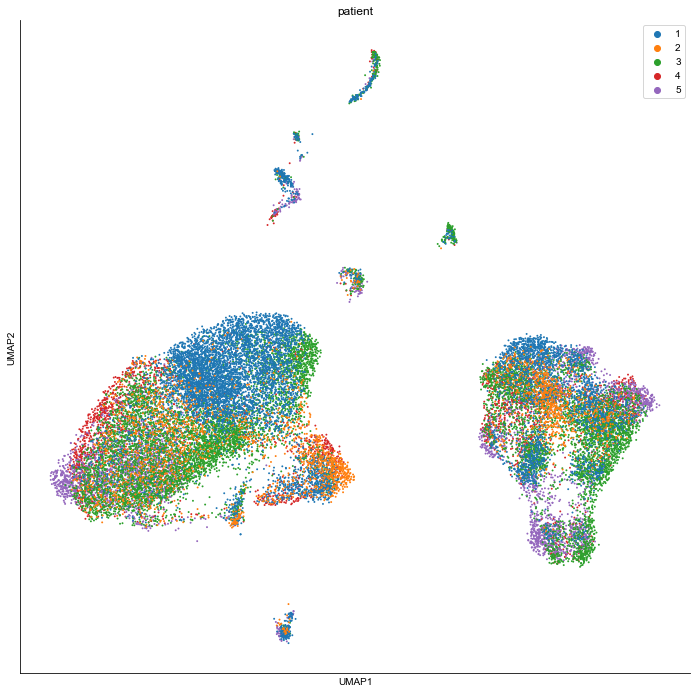

In [24]:
ax = sc.pl.umap(
    ds, 
    color="patient", 
    size=15, 
    show=False
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
h, l = ax.get_legend_handles_labels()
ax.legend(h, l)

Macrophage markers

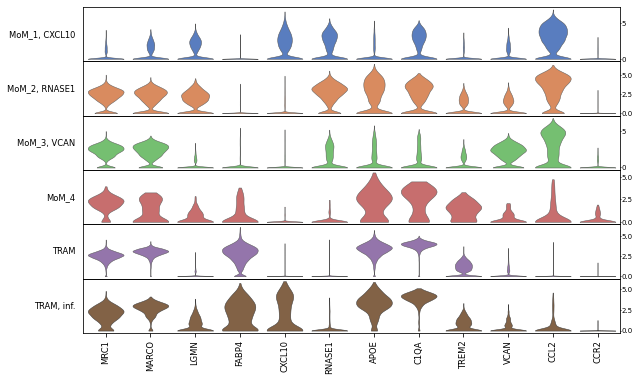

In [8]:
clusters = pd.Series(ds.obs.cluster.unique().astype(str))
clusters = clusters[clusters.str.match("^MoM|TRAM")]

markers = [
    "MRC1", "MARCO", "LGMN", "FABP4", "CXCL10", "RNASE1", "APOE", "C1QA", "TREM2", "VCAN", "CCL2", "CCR2"
]
ax = sc.pl.stacked_violin(
    ds[ds.obs.cluster.isin(clusters), :],
    markers,
    groupby="cluster",
    rotation=90,
    figsize=(10, 6),
    show=False
);

In [9]:
for i in ax:
    pos = i.get_position()
    pos.p0[0] = 0.15
    pos.p1[0] = 0.98
#     pos.p1[1] = 0.98
    i.set_position(pos)

In [10]:
ax[0].figure.savefig("09plots/09macrophage-markers.pdf")

## SARS reads

../lib/script/scanpy.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


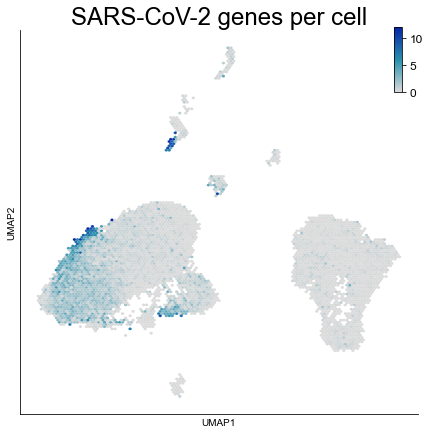

In [10]:
fig = sc_utils.feature_plot(ds, "n_sars_genes", gridsize=(120, 80), linewidths=0.05, figsize=(6, 6))
fig.axes[0].set_title("SARS-CoV-2 genes per cell", fontsize=24)
fig.axes[1].yaxis.set_tick_params(labelsize=12)
fig.axes[1].yaxis.set_ticks([0, 5, 10])
fig.savefig("11plots/4D_n_sars_genes.pdf")

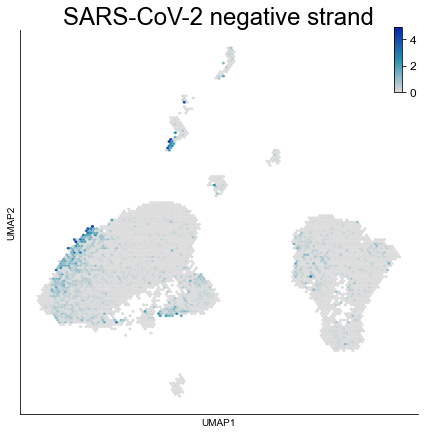

In [11]:
fig = sc_utils.feature_plot(ds, "SARS-CoV-2-Antisense", gridsize=(120, 80), figsize=(6, 6), linewidths=0.05)
fig.axes[0].set_title("SARS-CoV-2 negative strand", fontsize=24)
fig.axes[1].yaxis.set_tick_params(labelsize=12)
fig.axes[1].yaxis.set_ticks([0, 2, 4])
fig.savefig("11plots/S4C_sars-negative.pdf")

## Infected macrophage recruitment signature

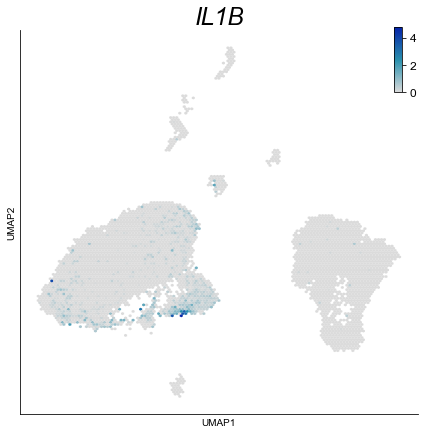

In [12]:
fig = sc_utils.feature_plot(ds, "IL1B", gridsize=(120, 80), figsize=(6, 6), linewidths=0.05)
fig.axes[0].set_title("IL1B", fontstyle="italic", fontsize=24)
fig.axes[1].yaxis.set_tick_params(labelsize=12)
fig.axes[1].yaxis.set_ticks([0, 2, 4])
fig.savefig("11plots/4X_IL1B.pdf")

../lib/script/scanpy.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


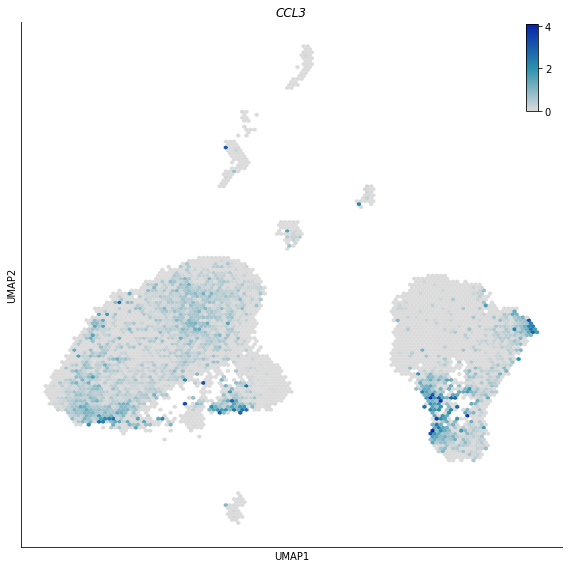

In [15]:
fig = sc_utils.feature_plot(ds, "CCL3", gridsize=(120, 80), figsize=(8, 8))
fig.axes[0].set_title("CCL3", fontstyle="italic")
fig.savefig("11plots/4Y_CCL3.pdf")

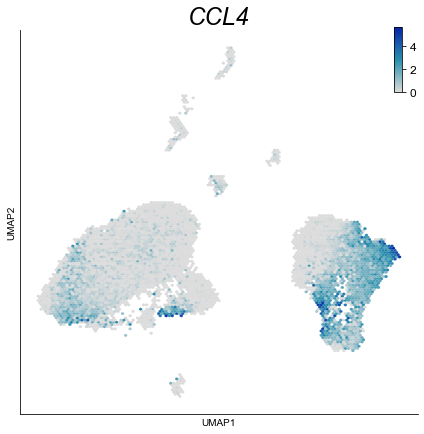

In [13]:
fig = sc_utils.feature_plot(ds, "CCL4", gridsize=(120, 80), figsize=(6, 6))
fig.axes[0].set_title("CCL4", fontstyle="italic", fontsize=24)
fig.axes[1].yaxis.set_tick_params(labelsize=12)
fig.axes[1].yaxis.set_ticks([0, 2, 4])
fig.savefig("11plots/4Z_CCL4.pdf")

../lib/script/scanpy.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


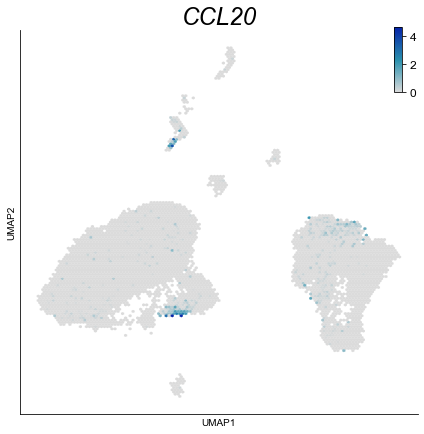

In [49]:
fig = sc_utils.feature_plot(ds, "CCL20", gridsize=(120, 80), figsize=(6, 6))
fig.axes[0].set_title("CCL20", fontstyle="italic", fontsize=24)
fig.axes[1].yaxis.set_tick_params(labelsize=12)
fig.axes[1].yaxis.set_ticks([0, 2, 4])
fig.savefig("11plots/4XX_CCL20.pdf")

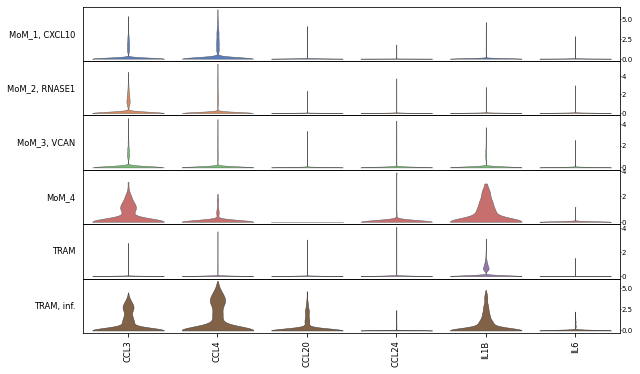

In [20]:
clusters = pd.Series(ds.obs.cluster.unique().astype(str))
clusters = clusters[clusters.str.match("^MoM|TRAM")]

markers = [
    "CCL3", "CCL4", "CCL20", "CCL24", "IL1B", "IL6"
]
ax = sc.pl.stacked_violin(
    ds[ds.obs.cluster.isin(clusters), :],
    markers,
    groupby="cluster",
    rotation=90,
    figsize=(10, 6),
    show=False
);

## Interferon response

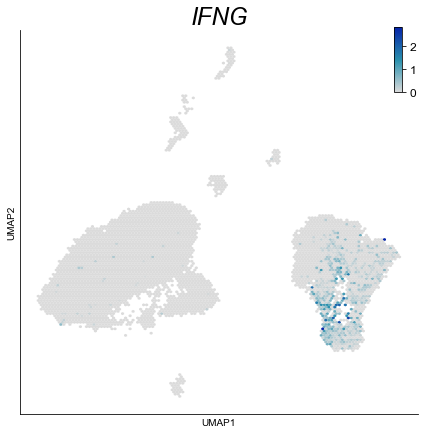

In [14]:
fig = sc_utils.feature_plot(ds, "IFNG", gridsize=(120, 80), linewidths=0.05, figsize=(6, 6))
fig.axes[0].set_title("IFNG", fontstyle="italic", fontsize=24)
fig.axes[1].yaxis.set_tick_params(labelsize=12)
fig.axes[1].yaxis.set_ticks([0, 1, 2])
fig.savefig("11plots/4C_IFNG.pdf")

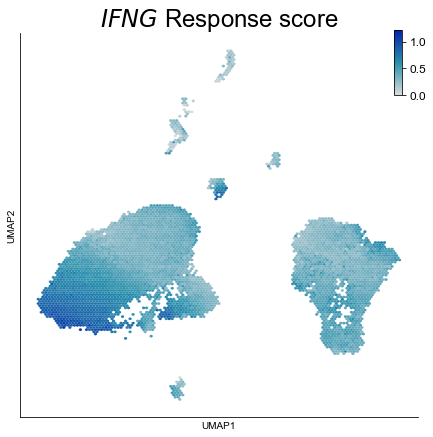

In [15]:
fig = sc_utils.feature_plot(ds, "IFNG Response", gridsize=(120, 80), figsize=(6, 6), linewidths=0.05)
fig.axes[0].set_title("$IFNG$ Response score", fontsize=24)
fig.axes[1].yaxis.set_tick_params(labelsize=12)
fig.axes[1].yaxis.set_ticks([0, 0.5, 1.0])
fig.savefig("11plots/S4H_IFNG_response.pdf")

../lib/script/scanpy.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


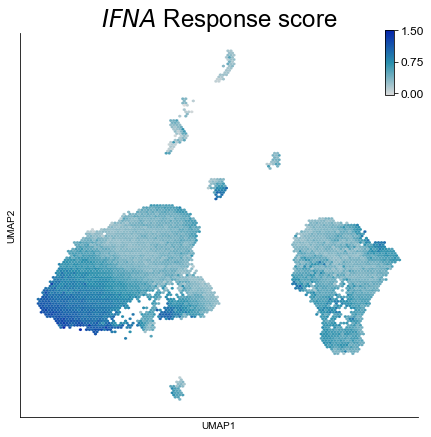

In [74]:
fig = sc_utils.feature_plot(ds, "IFNA Response", gridsize=(120, 80), linewidths=0.05, figsize=(6, 6))
fig.axes[0].set_title("$IFNA$ Response score", fontsize=24)
fig.axes[1].yaxis.set_tick_params(labelsize=12)
fig.axes[1].yaxis.set_ticks([0, 0.75, 1.5])
p = fig.axes[1].get_position()
p.x0 -= 0.02
p.x1 -= 0.02
fig.axes[1].set_position(p)
fig.savefig("11plots/S4G_IFNA_response.pdf")

## Heatmap of macrophage markers, cytokines and IFNA/G response scores

In [33]:
mac_clusters = ds.obs.cluster[ds.obs.cluster.str.match("MoAM|TRAM")].astype(str).unique()
ds_macs = ds[ds.obs.cluster.isin(mac_clusters), :].copy()

In [35]:
ds_macs.obs["cluster_p"] = ds_macs.obs.cluster.astype(str) + ", pt." + ds_macs.obs.patient.astype(str)

In [36]:
(ds_macs.obs.cluster_p == "MoAM3, pt.5").sum()

2

In [37]:
(ds_macs.obs.cluster_p == "MoAM2, pt.5").sum()

23

In [38]:
ds_macs = ds_macs[ds_macs.obs.cluster_p != "MoAM3, pt.5", :]

In [39]:
genes_of_i = """IL1R2
CCL8
CALHM6
PLTP
RNASE1
STAB1
CCL2
MAFB
CD14
CSF1R
ITGAM
VCAN
CCL18
TREM2
MRC1
C1QA
FBP1
OLR1
MARCO
MCEMP1
MSR1
FABP4
RBP4
INHBA""".split("\n")

cytokines = [
    "IL1B", "CCL3", "CCL4", "CCL20", "CXCL9",
    "CXCL10", "CXCL11", "TNFSF10", "DEFB1",
    "IL1RN", "IL27"
]

In [40]:
markers_expr = []
ifn_scores = []
all_genes = genes_of_i + cytokines
clusters = ds_macs.obs.cluster_p.astype(str).unique()
clusters.sort()
for g in clusters:
    mean_exp = ds_macs.raw.X[(ds_macs.obs.cluster_p == g).values, :][:, ds_macs.var_names.isin(all_genes)].mean(axis=0).A.reshape(-1)
    markers_expr.append(mean_exp)

for g in clusters:
    mean_exp = ds_macs.obs.loc[(ds_macs.obs.cluster_p == g).values, ["IFNA Response", "IFNG Response"]].mean(axis=0).values
    ifn_scores.append(mean_exp)

In [41]:
markers_expr = pd.DataFrame(markers_expr, columns=ds_macs.var_names[ds_macs.var_names.isin(all_genes)], index=clusters)

In [42]:
ifn_scores = pd.DataFrame(ifn_scores, columns=["IFNA Response", "IFNG Response"], index=clusters)

In [43]:
total_expr = pd.concat([markers_expr, ifn_scores], axis=1)
total_expr

,C1QA,CALHM6,CCL18,CCL2,CCL20,CCL3,CCL4,CCL8,CD14,CSF1R,...,OLR1,PLTP,RBP4,RNASE1,STAB1,TNFSF10,TREM2,VCAN,IFNA Response,IFNG Response
"MoAM1, pt.1",1.232893,1.056969,0.535322,3.874283,0.029713,0.366952,0.347612,1.617993,2.032677,1.061603,...,0.720529,0.442686,0.044802,1.400867,0.759815,1.384065,0.275292,1.308206,0.747743,0.622658
"MoAM1, pt.2",1.924601,1.683549,0.447991,2.395735,0.006392,0.409512,0.456267,1.681765,1.712572,0.795168,...,0.511314,0.685715,0.030506,2.421236,0.629825,1.607385,0.212908,0.800006,0.757683,0.647777
"MoAM1, pt.3",1.792330,2.199127,0.299115,2.397063,0.011368,0.292732,0.509835,1.169504,1.893333,0.746592,...,0.416329,0.522061,0.002625,2.171073,0.495461,1.830399,0.504964,0.516915,0.815453,0.682244
"MoAM1, pt.4",1.561908,1.696323,0.375535,3.102721,0.022148,0.366827,0.535312,1.943448,0.907414,0.528294,...,0.124876,0.302489,0.018384,0.975699,0.539142,1.590124,0.170724,0.694296,0.733465,0.622731
"MoAM1, pt.5",2.295702,2.069609,0.270712,3.101904,0.022581,0.221929,0.416618,2.067878,1.464739,0.435967,...,0.081314,0.296097,0.008730,1.779139,0.471706,1.728511,0.050706,0.640836,0.910613,0.736245
"MoAM2, pt.1",1.874723,0.356540,1.892230,3.803761,0.011256,0.379996,0.185235,0.435953,2.036329,1.074781,...,0.683030,1.123932,0.025668,2.472102,0.958618,0.143385,0.730380,1.149490,0.331121,0.333452
"MoAM2, pt.2",3.319201,0.843582,1.426556,1.675921,0.000000,0.128656,0.065562,0.327882,1.635915,1.165063,...,0.725322,1.178663,0.105649,3.271191,1.034665,0.401800,1.001728,0.837482,0.385614,0.377536
"MoAM2, pt.3",2.982937,0.790178,1.405753,2.370828,0.003847,0.212660,0.145416,0.264186,1.875191,1.045364,...,0.479549,1.120529,0.011552,2.552804,0.842879,0.430893,1.484163,0.665537,0.441844,0.411307
"MoAM2, pt.4",3.205131,0.559127,2.345742,2.722934,0.020807,0.182593,0.175318,0.438141,1.108030,0.691509,...,0.161636,0.921876,0.016654,3.070818,0.961219,0.157592,0.928774,0.596842,0.308530,0.314580
"MoAM2, pt.5",2.525468,0.747659,1.580176,2.832307,0.000000,0.053726,0.175358,1.184844,0.580278,0.393735,...,0.063388,0.420946,0.000000,2.186322,0.293554,0.539923,0.028163,0.429411,0.546335,0.434372


In [45]:
total_expr.min()

C1QA             0.638472
CALHM6           0.137098
CCL18            0.157502
CCL2             0.022978
CCL20            0.000000
CCL3             0.003983
CCL4             0.000000
CCL8             0.009507
CD14             0.580278
CSF1R            0.000000
CXCL10           0.028838
CXCL11           0.000000
CXCL9            0.000000
DEFB1            0.026208
FABP4            0.000000
FBP1             0.000000
IL1B             0.000000
IL1R2            0.000000
IL1RN            0.032521
IL27             0.018867
INHBA            0.000000
ITGAM            0.000000
MAFB             0.270402
MARCO            0.516417
MCEMP1           0.000000
MRC1             0.218476
MSR1             0.164877
OLR1             0.063388
PLTP             0.000000
RBP4             0.000000
RNASE1           0.090765
STAB1            0.000000
TNFSF10          0.143385
TREM2            0.028163
VCAN             0.168290
IFNA Response    0.267098
IFNG Response    0.287360
dtype: float64

In [46]:
total_expr = (total_expr - total_expr.min()) / (total_expr.max() - total_expr.min())

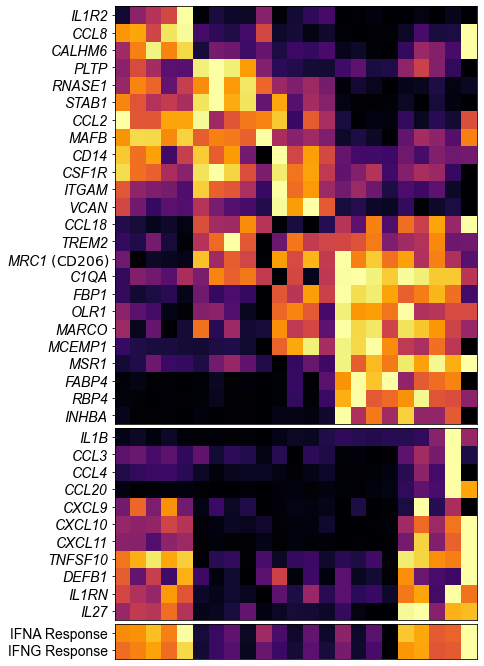

In [47]:
fig, axes = plt.subplots(
    nrows=3, 
    sharex=True, 
    figsize=(6.5, 12), 
    gridspec_kw={
        "height_ratios": [len(genes_of_i), len(cytokines), 2],
        "hspace": 0.02
    }
)
axes[0].pcolormesh(total_expr.loc[:, reversed(genes_of_i)].T.to_numpy(), cmap="inferno")
axes[0].set_yticks(pd.Series(range(len(genes_of_i))) + 0.5)
axes[0].set_yticklabels(
    reversed([r"MRC1 $\mathrm{(CD206)}$" if g == "MRC1" else g for g in genes_of_i]), 
    fontstyle="italic",
    fontsize=14
)
troublemaker = axes[0].yaxis.get_majorticklabels()[9]
troublemaker.set_x(troublemaker._x + 0.006)
# troublemaker.set_y = lambda y: mpl.text.Text.set_y(troublemaker, y + 0)
axes[0].tick_params(bottom=False, labelbottom=False)

axes[1].pcolormesh(total_expr.loc[:, reversed(cytokines)].T.to_numpy(), cmap="inferno")
axes[1].set_yticks(pd.Series(range(len(cytokines))) + 0.5)
axes[1].set_yticklabels(reversed(cytokines), fontstyle="italic", fontsize=14)
axes[1].tick_params(bottom=False, labelbottom=False)

axes[2].pcolormesh(total_expr.loc[:, ["IFNG Response", "IFNA Response"]].T.to_numpy(), cmap="inferno")
axes[2].set_yticks([0.5, 1.5])
axes[2].set_yticklabels(["IFNG Response", "IFNA Response"], fontsize=14)
axes[2].tick_params(bottom=False, labelbottom=False)

/projects/b1038/tools/pyenv/versions/3.6.9/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


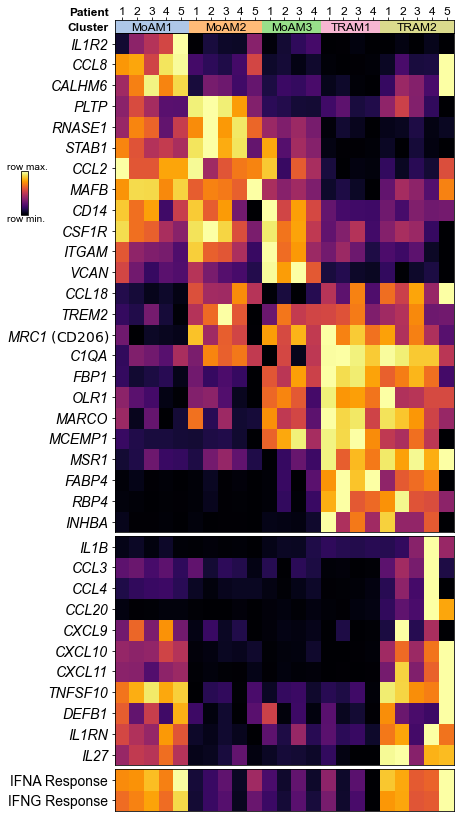

In [51]:
ax0bbox = axes[0].get_position()
labs = fig.add_axes((ax0bbox.x0, ax0bbox.y1, ax0bbox.width, 0.015), sharex=axes[0])
labs.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False, top=True, labeltop=True)
clusters = pd.Series(total_expr.index.str.split(",")).apply(lambda x: x[0]).value_counts().sort_index()
pats = pd.Series(total_expr.index.str.split(",")).apply(lambda x: x[1][4:])
s = 0
for i, n in enumerate(clusters.index):
    w = clusters[n]
    labs.add_patch(mpl.patches.Rectangle(
        (s, 0), 
        w, 
        1, 
        facecolor=cluster_colors[n]
    ))
    labs.annotate(
        n, 
        (w / 2 + s, 0.45),
        ha="center",
        va="center",
        color="black",
        fontsize=12
    )
    s += w
labs.set_xticks(pd.Series(range(pats.size)) + 0.5)
labs.set_xticklabels(pats, fontsize=12)
labs.tick_params(pad=0)
labs.annotate("Patient", (-0.4, 1.4), annotation_clip=False, ha="right", fontweight="bold", fontsize=12)
labs.annotate("Cluster", (-0.4, 0.2), annotation_clip=False, ha="right", fontweight="bold", fontsize=12)

cax = fig.add_axes((0.095, 0.67, 0.015, 0.05))
cax = fig.colorbar(
    mpl.cm.ScalarMappable(norm=None, cmap="inferno"),
    cax=cax,
    ticks=[]
)
cax.ax.annotate("row min.", (-2, 0), va="top", annotation_clip=False)
cax.ax.annotate("row max.", (-2, 1), va="bottom", annotation_clip=False)

available_height = axes[2].get_position().x0 + 0.02
proportions = [len(genes_of_i), len(cytokines), 2]
move = 0
for i, ax in enumerate(fig.axes):
    p = ax.get_position()
    if i == 4:
        p.x0 -= 0.05
        p.x1 -= 0.05
    else:
        p.x0 += 0.12
        p.x1 += 0.07
    p.y0 += 0.06
    p.y1 += 0.06
    if i < len(proportions):
        p.y1 -= move
        move += available_height / np.sum(proportions) * proportions[i]
        p.y0 -= move
    ax.set_position(p)

fig.savefig("11plots/4B_mac_markers_v2.pdf")
fig

## IL6 plot

In [50]:
il6_mask = ds.var_names == "IL6"
il6_mean_rows = []
X = ds.raw.X.todense()
for i, p in enumerate(ds.obs.patient.cat.categories):
    for j, c in enumerate(ds.obs.cluster.astype("category").cat.categories):
        expr = X[(ds.obs.cluster == c) & (ds.obs.patient == p),:][:, il6_mask].A.reshape(-1)
        pct = np.sum(expr > 0) / (ds.obs.cluster == c).sum()
        mean = np.mean(expr)
        il6_mean_rows.append((i, j, p, c, mean, pct, expr.shape[0]))

/projects/b1038/tools/pyenv/versions/3.6.9/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/projects/b1038/tools/pyenv/versions/3.6.9/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [51]:
il6_expr = pd.DataFrame(il6_mean_rows, columns=["idx_p", "idx_c", "patient", "cluster", "mean_expr", "pct", "count"])
il6_expr.fillna(0, inplace=True)

In [52]:
il6_expr.pct.describe()

count    95.000000
mean      0.002079
std       0.006681
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000297
max       0.050926
Name: pct, dtype: float64

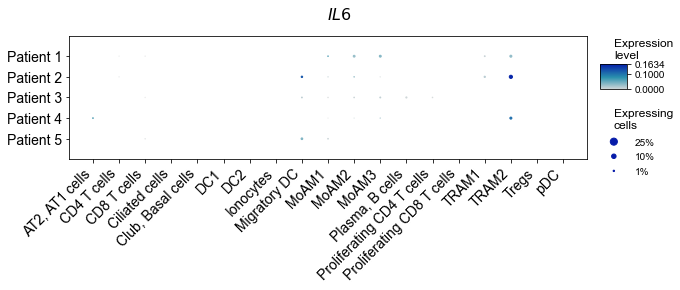

In [53]:
fig = plt.figure(figsize=(10, 4))
gs = mpl.gridspec.GridSpec(2, 2, figure=fig, width_ratios=(19, 1), wspace=0.05, hspace=0.3)
ax1 = fig.add_subplot(gs[:, 0])
cax = fig.add_subplot(gs[0, 1])
sax = fig.add_subplot(gs[1, 1])
x = ax1.scatter(
    il6_expr.idx_c, 
    il6_expr.idx_p * -1, 
    s=il6_expr.pct * 200, 
    c=il6_expr.mean_expr, 
    cmap=sc_utils.expr_colormap()
)
fig.subplots_adjust(bottom=0.45)
fig.colorbar(x, cax=cax, ticks=[0, 0.1, il6_expr.mean_expr.max()])
cax.set_title("Expression\nlevel", ha="left")
cax_p = cax.get_position()
cax_p.y1 -= 0.1
cax.set_position(cax_p)

ax1.set_yticks(range(0, -5, -1))
ax1.set_yticklabels("Patient " + pd.Series(range(1, 6)).astype(str), fontsize=14)
ax1.set_ylim(-5, 1)
ax1.set_xticks(range(ds.obs.cluster.unique().size))
ax1.set_xticklabels(ds.obs.cluster.astype("category").cat.categories, rotation=45, fontsize=14, ha="right")

sax.scatter(
    [0, 0, 0],
    [0, 1, 2],
    np.array([0.01, 0.1, 0.25]) * 200,
    c=[[6/256, 27/256, 170/256]]*3
)
sax.set_ylim(-0.2, 2.5)
sax.tick_params(left=False, labelleft=False, labelright=True, bottom=False, labelbottom=False)
sax.set_yticks([0, 1, 2])
sax.set_yticklabels(["1%", "10%", "25%"])
sax.set_title("Expressing\ncells", ha="left")
for x in sax.spines.keys():
    sax.spines[x].set_visible(False)
sax_p = sax.get_position()
sax_p.y0 -= 0.05
sax_p.y1 -= 0.1
sax.set_position(sax_p)
fig.suptitle("$IL6$", fontsize=16)
fig.savefig("11plots/S4K_il6_dot.pdf")

## Combined SARS-CoV-2 read coverage plot

In [72]:
gtf = "../01human-sars-ref/NC_045512.2.gtf"
depth = "../data/02preprint/sars-bam/combined.depth"

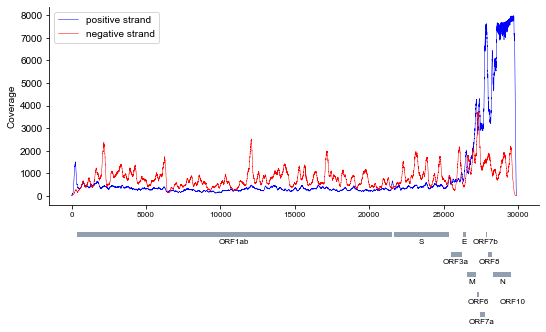

In [98]:
db = gffutils.create_db(gtf, ':memory:')
data = pd.read_table(depth, header=None)

line_height = 10
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(data[1], data[2], c="b", label="positive strand", lw=0.5)
ax.plot(data[1], data[5], c="r", label="negative strand", lw=0.5)
ax.legend()
ax.set_ylabel("Coverage")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis="x", labelsize=8)
lines = []
fig.canvas.draw()
fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.4)
data_fig = ax.transData + fig.transFigure.inverted()
line_height = fig.transFigure.inverted().transform([0, line_height])[1]
for f in db.features_of_type("exon"):
    start = data_fig.transform([f.start, 0])[0]
    end = data_fig.transform([f.end, 0])[0]

    r = mpl.patches.Rectangle(
        (start, 0.4 - 3.2 * line_height),
        end - start,
        line_height * 0.6,
        fill=True,
        facecolor="#90a0b0",
        linewidth=1,
        zorder=5,
        edgecolor="white"
    )
    fig.add_artist(r)
    rx, ry = r.get_xy()
    cx = rx + r.get_width() / 2
    cy = ry + r.get_height() / 2

    ann = mpl.text.Text(
        cx, cy,
        f.attributes["gene_name"][0],
        color="black",
        ha="center",
        va="top",
        fontsize=8,
        zorder=10
    )
    fig.add_artist(ann)

    rect_bb = r.get_window_extent()
    rect_bb = rect_bb.transformed(fig.transFigure.inverted())
    text_bb = ann.get_window_extent()
    text_bb = text_bb.transformed(fig.transFigure.inverted())
    margin = 0.01
    if len(lines) == 0:
        lines.append((rect_bb, text_bb))
    else:
        found = False
        for i, prev_bb in enumerate(lines):
            if prev_bb[0].x1 + margin < text_bb.x0 and prev_bb[1].x1 + margin < text_bb.x0:
                lines[i] = rect_bb, text_bb
                found = True
                break
        if not found:
            i = len(lines)
            lines.append((rect_bb, text_bb))
        if i > 0:
            r.set_y(r.get_y() - line_height * i * 2)
        ann.set_position((cx, cy - line_height * i * 2))
    ann_pos = ann.get_position()
    ann.set_position((ann_pos[0], ann_pos[1] - 0.5 * line_height))
fig.savefig("11plots/S4D_sars_reads.pdf")

## Plot full object

In [6]:
ds10 = sc.read_h5ad("../data/02preprint/10obj-named.h5ad")

In [182]:
ds.obs.cluster.unique().size

19

In [183]:
ds10.obs.cluster.unique().size

21

In [8]:
ds10.obs.cluster = ds10.obs.cluster.astype(str)
ds10.obs.cluster = ds10.obs.cluster.str.replace("MoM_", "MoAM")

In [9]:
ds10.obs.cluster.replace({
    "MoAM1, IL1R2": "MoAM1",
    "MoAM2, CCL18": "MoAM2",
    "MoAM3, VCAN":  "MoAM3",
    "MoAM5, CCL3L1": "MoAM5",
    "TRAM":         "TRAM1",
    "TRAM, inf.":   "TRAM2",
    "pDCs":         "pDC",
    "Plf. CD4 T cells": "Proliferating CD4 T cells",
    "Plf. CD8 T cells": "Proliferating CD8 T cells",
}, inplace=True)

In [ ]:
ds10_colors = pd.Series(index=sorted(ds10.obs.cluster.unique()))
ds10_colors[cluster_colors.index] = cluster_colors
ds10_colors.name = "color"
ds10_colors

In [11]:
ds10_colors["MoAM4"] = sc.pl.palettes.default_20[-1]
ds10_colors["MoAM5"] = "#6aa074"

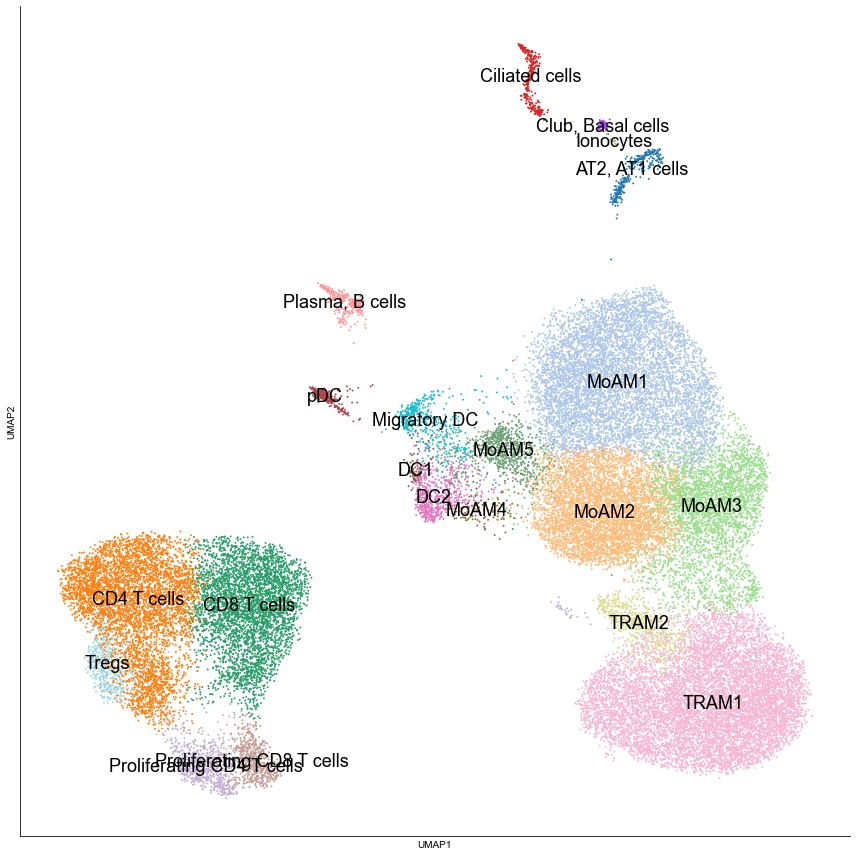

In [214]:
ax = sc.pl.umap(
    ds10, 
    color="cluster", 
    size=15, 
    legend_loc="on data", 
    show=False, 
    legend_fontsize=18, 
    legend_fontweight="normal",
    palette=list(ds11_colors)
  #  legend_fontoutline=3
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("")
ax.figure.tight_layout()
ax.figure.savefig("11plots/S4E_umap.pdf")

In [30]:
cluster_colors = pd.Series(ds10.uns["cluster_colors"])
cluster_colors.index = ds11.obs.cluster.cat.categories
cluster_colors.name = "color"

In [31]:
cluster_colors

AT2, AT1 cells               #023fa5
CD4 T cells                  #d6bcc0
CD8 T cells                  #4a6fe3
Ciliated cells               #e6afb9
Club, Basal cells            #11c638
DC1                          #ead3c6
DC2                          #0fcfc0
Ionocytes                    #f3e1eb
Migratory DC                 #7f7f7f
MoAM1                        #336600
MoAM2                        #bec1d4
MoAM3                        #8e063b
MoAM4                        #b5bbe3
MoAM5, CCL3L1                #d33f6a
Plasma, B cells              #c6dec7
Proliferating CD4 T cells    #ef9708
Proliferating CD8 T cells    #d5eae7
TRAM1                        #f79cd4
TRAM2                        #1ce6ff
Tregs                        #7d87b9
pDC                          #bb7784
Name: color, dtype: object

In [212]:
ds10_colors.to_csv("10obj-colors.tsv", index_label="metadataValue", sep="\t", header=True)

## Non-COVID-19 patient

In [14]:
ds10.obs["isp6"] = ds10.obs.patient == "6"

In [15]:
ds10.obs["isp6"] = ds10.obs["isp6"].astype("category")

In [16]:
ds10.obs.isp6 = ds10.obs.isp6.cat.rename_categories({True: "Patient 6", False: "Other patients"})

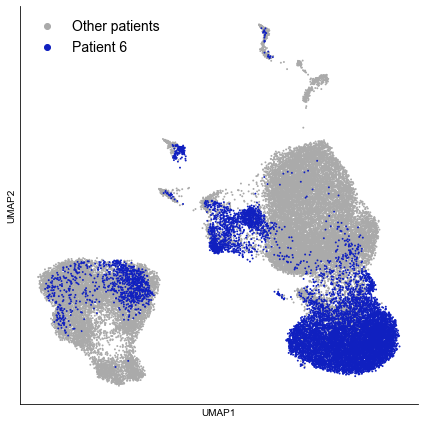

In [19]:
mpl.rcParams["figure.figsize"] = (6, 6)
ax = sc.pl.umap(
    ds10, 
    color="isp6", 
    size=15, 
#     legend_loc="upper right", 
    show=False, 
    legend_fontsize=14, 
    legend_fontweight="normal",
    palette=["#aaaaaa", "#1020c0"]
)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, frameon=False, fontsize=14, loc="upper left")
ax.figure.tight_layout()
ax.figure.savefig("11plots/S4F_patient6.pdf")